In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sympy as sp
from sympy.plotting import plot3d
import pyaudio
import threading
import time
import random
import json
import collections as cl

In [2]:
class play_wave:
        def __init__(self):
            self.p = pyaudio.PyAudio()
            self.stream = self.p.open(format=pyaudio.paFloat32, channels=2, rate=44100, output=1)
        def close(self):
            self.stream.close()
            self.p.terminate()
        def marge(self, s1, s2):
            if s1.shape[0] != s2.shape[0]: return []
            signal = np.empty(s1.shape[0] * 2)
            for i in range(signal.shape[0]):
                if i % 2 == 0: signal[i] = s1[int(i / 2)]
                else: signal[i] = s2[int(i / 2)]
            return signal
        def set_signal(self, s, r):
            self.signal = s
            self.ratio = r
            return
        def play(self, s, r):
            if r < 0 or 1 < r: return
            signal = self.marge(s * (1 - r), s * r) * 0.12
            self.stream.write(signal.astype(np.float32).tostring())
        def run(self):
            self.ratio = -1
            while True:
                if self.ratio >= 0:
                    self.play(self.signal, self.ratio)
                elif self.ratio == -2:
                    self.close()
                    break
                else:
                    time.sleep(0.1)

class play_wave_monoral:
        def __init__(self):
            self.p = pyaudio.PyAudio()
            self.stream = self.p.open(format=pyaudio.paFloat32, channels=1, rate=44100, output=1)
        def close(self):
            self.stream.close()
            self.p.terminate()
        def play(self, signal):
            signal *= 0.1
            self.stream.write(signal.astype(np.float32).tostring())

In [3]:
class create_waon:
    def __init__(self):
        return
    def sine(self, frequency, length, rate):
        length = int(length * rate)
        factor = float(frequency) * (np.pi * 2) / rate
        return np.sin(np.arange(length) * factor)
    def return_waon(self, nums, levels):
        result = np.zeros(44100)
        for i, (n, l) in enumerate(zip(nums, levels)):
            s = 44100 - int(44100 * (1-0.1*i))
            result[s: ] += self.sine(440 * (2 ** (1/12)) ** n , 1 - 0.1*i, 44100) * l
        return result
    def major(self, pitch):
        return self.return_waon([pitch, pitch+4, pitch+7], [1,1,1])
    def minor(self, pitch):
        return self.return_waon([pitch, pitch+3, pitch+7], [1,1,1])
    def dim(self, pitch):
        return self.return_waon([pitch, pitch+3, pitch+6], [1,1,1])
    def aug(self, pitch):
        return self.return_waon([pitch, pitch+4, pitch+8], [1,1,1])

In [4]:
def create_plane(a, b, c):
    ab = b - a
    ac = c - a
    normal = np.cross(ab, ac)
    return normal

def random_plane():
    normal = np.zeros(3,)
    
    while(normal[0] == 0 or normal[2] == 0):
        a = np.array([0,0,0])
        b = np.random.randint(-5,5,(3,))
        c = np.random.randint(-5,5,(3,))
        normal = create_plane(a,b,c)
        
    return normal

def plot_plane(normal):
    d = - 1 * np.zeros(3,).dot(normal)
    xx, yy = np.meshgrid(range(-10,10), range(-10,10))
    z = (-normal[0] * xx - normal[1] * yy - d) * 1. / normal[2]

    n = np.outer(normal, np.arange(-2,2,0.1)) + np.array([[0],[0],[z[10,10]]])

    plt3d = plt.figure(figsize=(6,6)).gca(projection='3d')
    plt3d.plot_surface(xx, yy, z, alpha = 0.7)
    plt3d.plot(n[0],n[1],n[2], color="red", ms=4, mew=1)
    plt3d.view_init(0,0)
    plt3d.set_xlabel("X-axis")
    plt3d.set_ylabel("Y-axis")
    plt3d.set_zlabel("Z-axis")
    plt.plot([0],[0],[z[10,10]], color="blue", marker = ".", ms=15, mew = 1)
    plt.show()

In [5]:
def plane_sound(normal = None):
    if normal == None:
        normal = random_plane()
    #normal = np.array([5,0,20])
    #plot_plane(normal)

    eyes = (10,0,0)
    face = sp.Plane(sp.Point3D(eyes), normal_vector = eyes)

    p = sp.Plane(sp.Point3D(0,0,0), normal_vector = normal)
    l = sp.Line3D(sp.Point3D(eyes), sp.Point3D(0,0,0))
    nl = sp.Line3D(p.intersection(l)[0], direction_ratio = normal)

    point = face.intersection(nl)
    #print(point[0].evalf())
    x, y, z = float(point[0].x), float(point[0].y), float(point[0].z)
    angle = calc_angle(y, z)
    dist = (y ** 2 + z ** 2) ** 0.5
    return normal, angle, dist, angle

def calc_angle(y, z):
    if y == 0:
        angle = 90 * np.sign(z)
    elif y > 0:
        angle = np.arctan(z / y) * 180 / np.pi
    else:
        angle = np.arctan(z / y) * 180 / np.pi + 180
    #angle -= 90
    return angle

def calc_ratio(angle):
    ratio = np.cos(np.pi * angle / 180)
    ratio = (ratio + 1) / 2
    #print(angle, ratio)
    return ratio

In [6]:
def get_pos_12div(ndiv):
    x = 10
    y = 10 * np.cos(ndiv * np.pi / 6)
    z = 10 * np.sin(ndiv * np.pi / 6)
    if z == 0: z = 0.0000000001
    return [x, y, z]

def check_answer(order, answer):
    correct = 0
    for o, a in zip(order, answer):
        if o == a:
            correct += 1
    return correct

def save_result(name, pref, order, answer, correct, correct_rate):
    data = cl.OrderedDict()
    data["order"] = order
    data["answer"] = answer
    data["correct"] = correct
    data["correct_rate"] = correct_rate
    with open('./experiment_data/'+name + '_' + pref + '.json', 'w') as f:
        json.dump(data, f, indent=4)
    return

def set_order(mode, N):
    if mode == '12A':
        order = [0,1,2,3,4,5,6,7,8,9,10,11] * N
    elif mode == '7U':
        order = [0,1,1,2,2,3,3,4,4,5,5,6] * N
    elif mode == '7R':
        order = [9,10,10,11,11,0,0,1,1,2,2,3] * N
    else:
        order = []
    random.shuffle(order)
    return order

def set_freq_ratio(mode, angle):
    freq = 440
    ratio = 0.5
    if mode == '12A':
        freq = 440 * 2 ** (np.sin(np.pi * angle / 180))
        ratio = calc_ratio(angle)
    elif mode == '7U':
        ratio = calc_ratio(angle)
    elif mode == '7R':
        freq = 440 * 2 ** (np.sin(np.pi * angle / 180))
    return freq, ratio

In [7]:
# ランダムテスト
# mode = 12A(全方位), 7U(上側), 7R(右側)
# N = 何セットテストするか

def random_test(order, mode = '12A', N = 3):
    pw = play_wave()
    pw_thread = threading.Thread(target = pw.run)
    pw_thread.start()
    cw = create_waon()

    name = input('実験対象者の名前:')
    pref = mode + 'x' + str(N)

    modecheck = set_order(mode, N)
    if len(modecheck) == 0:
        print("エラー: modeの値が不正です")
        return
    answer = []

    for i, o in enumerate(order):
        normal, angle, dist, angle = plane_sound(get_pos_12div(o))
        freq, ratio = set_freq_ratio(mode, angle)
        s = cw.sine(freq, 2, 44100) / np.log(dist)
        pw.set_signal(s, ratio)
        print(str(i+1)+"番目の答え:", o)
        time.sleep(1)
        pw.ratio = -1
        answer.append(int(input("回答:")))

    pw.ratio = -2

    correct = check_answer(order, answer)
    correct_rate = correct / len(order) * 100
    print("正答率:",  correct_rate, "%")

    save_result(name, pref, order, answer, correct, correct_rate)

In [30]:
# テスト前に例の提示
mode = '12A'

if mode == '12A':
    test_order = [0,1,2,3,4,5,6,7,8,9,10,11]
elif mode == '7U':
    test_order = [0,1,2,3,4,5,6]
else:
    test_order = [3,2,1,0,11,10,9]

pw = play_wave()
pw_thread = threading.Thread(target = pw.run)
pw_thread.start()
cw = create_waon()

for o in test_order:
    normal, angle, dist, angle = plane_sound(get_pos_12div(o))
    freq, ratio = set_freq_ratio(mode, angle)
    s = cw.sine(freq, 2, 44100) / np.log(dist)
    pw.set_signal(s, ratio)
    print("例の答え:", o, end="")
    time.sleep(1)
    pw.ratio = -1
    input()

pw.ratio = -2

例の答え: 0
例の答え: 1
例の答え: 2
例の答え: 3
例の答え: 4
例の答え: 5
例の答え: 6
例の答え: 7
例の答え: 8
例の答え: 9
例の答え: 10
例の答え: 11


In [31]:
order_7r = [0, 11, 10, 3, 10, 0, 11, 10, 9, 1, 11, 2, 1, 9, 9, 2, 0, 2, 1, 11, 1, 11, 11, 2, 1, 0, 10, 10, 2, 3, 0, 2, 10, 0, 1, 3]
order_7u = [6, 4, 2, 4, 0, 1, 5, 1, 6, 2, 1, 4, 5, 3, 6, 2, 2, 5, 3, 4, 3, 3, 5, 1, 5, 4, 0, 4, 2, 1, 3, 3, 0, 1, 2, 5]
order_12a = [11, 10, 7, 4, 8, 3, 1, 7, 1, 11, 11, 8, 9, 5, 0, 3, 6, 9, 5, 2, 0, 2, 5, 10, 0, 7, 10, 9, 8, 6, 3, 1, 6, 4, 2, 4]

random_test(order_12a, mode='12A', N = 3)

実験対象者の名前:masaki
1番目の答え: 11
回答:10
2番目の答え: 10
回答:11
3番目の答え: 7
回答:7
4番目の答え: 4
回答:4
5番目の答え: 8
回答:8
6番目の答え: 3
回答:3
7番目の答え: 1
回答:0
8番目の答え: 7
回答:6
9番目の答え: 1
回答:0
10番目の答え: 11
回答:10
11番目の答え: 11
回答:10
12番目の答え: 8
回答:9
13番目の答え: 9
回答:9
14番目の答え: 5
回答:4
15番目の答え: 0
回答:1
16番目の答え: 3
回答:3
17番目の答え: 6
回答:6
18番目の答え: 9
回答:9
19番目の答え: 5
回答:7
20番目の答え: 2
回答:2
21番目の答え: 0
回答:0
22番目の答え: 2
回答:2
23番目の答え: 5
回答:6
24番目の答え: 10
回答:10
25番目の答え: 0
回答:0
26番目の答え: 7
回答:6
27番目の答え: 10
回答:11
28番目の答え: 9
回答:10
29番目の答え: 8
回答:10
30番目の答え: 6
回答:6
31番目の答え: 3
回答:3
32番目の答え: 1
回答:2
33番目の答え: 6
回答:5
34番目の答え: 4
回答:4
35番目の答え: 2
回答:2
36番目の答え: 4
回答:3
正答率: 47.22222222222222 %


In [110]:
order = set_order('12A', 3)
print(order)

[11, 10, 7, 4, 8, 3, 1, 7, 1, 11, 11, 8, 9, 5, 0, 3, 6, 9, 5, 2, 0, 2, 5, 10, 0, 7, 10, 9, 8, 6, 3, 1, 6, 4, 2, 4]


In [65]:
pw = play_wave()
pw_thread = threading.Thread(target = pw.run)
pw_thread.start()
cw = create_waon()

normal, angle, dist, angle = plane_sound()
s = cw.sine(440 * 2 ** (np.sin(np.pi * angle / 180)), 1, 44100) / np.log(dist)
pw.set_signal(s, calc_ratio(angle))
time.sleep(2)
pw.ratio = -2

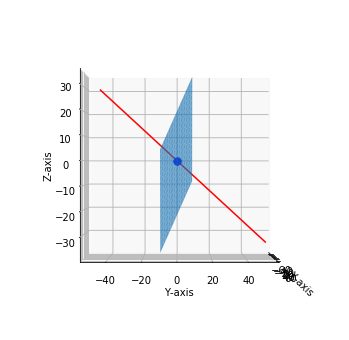

-32.61924307119283 8.244901155364351


In [11]:
plot_plane(normal)
print(angle, dist)